In [1]:
import json
import time

import gurobipy as gp
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline
import numpy as np
import pandas as pd
from gurobipy import GRB
from tqdm.auto import tqdm

from orc.branch import (
    branch_beasley, branch_reduced_costs, 
    branch_lp
)
from orc.callbacks import (
    ColumnInclusionCallback,
    LagrPenaltiesReductionCallback,
    PrimalHeurCallback
)
from orc.data_structures import (
    BranchAndBound, TimeLimitException
)
from orc.primal import dobson, greedy, hall_hochbaum
from orc.relaxation import subgrad_opt, lp_rel
from orc.utils import generate_problem

mpl.rcParams["font.family"] = ["serif"]
mpl.rcParams["font.serif"] = ["cmr10"]
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

# Primal heuristics comparisons

## Without fixed variables

In [2]:
table = []
funcs = [(greedy, "Greedy"), (dobson, "Dobson"),
         (hall_hochbaum, "Hall-Hochbaum")]
for rows, cols in tqdm(
    [(5, 10), (10, 20), (20, 50), (50, 100)], leave=False):
    res = {"Rows": rows, "Columns": cols, "Greedy": 0, 
           "Dobson": 0, "Hall-Hochbaum": 0}
    for i in tqdm(range(10)):
        A, b = generate_problem(rows, cols)
        v = []
        for f, name in funcs:
            ub = np.sum(A, axis=0) @ f(A, b, [], [])
            v.append(ub)
        j = np.argmin(v)
        best = funcs[j][1]
        res[best] += 1
    table.append(res)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [3]:
with open("results/primal.json", "w") as f:
    out = {"output": table}
    json.dump(out, f)

In [4]:
with open("results/primal.json", "r") as f:
    table = json.load(f)["output"]

In [5]:
df = pd.DataFrame(table)
df = df.set_index(["Rows", "Columns"])
df

,,Greedy,Dobson,Hall-Hochbaum
Rows,Columns,,,
5,10,1,7,2
10,20,1,3,6
20,50,0,0,10
50,100,0,0,10


In [6]:
s = df.style.highlight_max(axis=1, props="bfseries: ;")
print(s.to_latex(column_format="llccc", 
                 hrules=True, 
                 position_float="centering"))

\begin{table}
\centering
\begin{tabular}{llccc}
\toprule
 &  & Greedy & Dobson & Hall-Hochbaum \\
Rows & Columns &  &  &  \\
\midrule
5 & 10 & 1 & \bfseries 7 & 2 \\
10 & 20 & 1 & 3 & \bfseries 6 \\
20 & 50 & 0 & 0 & \bfseries 10 \\
50 & 100 & 0 & 0 & \bfseries 10 \\
\bottomrule
\end{tabular}
\end{table}



## With fixed variables

In [ ]:
np.random.seed(42)

table = []
funcs = [(greedy, "Greedy"), (dobson, "Dobson"),
         (hall_hochbaum, "Hall-Hochbaum")]
for rows, cols in tqdm(
    [(5, 10), (10, 20), (20, 50), (50, 100)], leave=False):
    res = {"Rows": rows, "Cols": cols, "Greedy": 0, 
           "Dobson": 0, "Hall-Hochbaum": 0}
    for i in tqdm(range(10)):
        A, b = generate_problem(rows, cols)
        fixed_n = int(cols * 0.3) 
        fixed = np.random.choice(
            A.shape[-1], fixed_n, replace=False)
        x0 = fixed[:int(fixed_n / 2)]
        x1 = fixed[int(fixed_n / 2) + 1:]
        x = np.ones(A.shape[-1])
        x[x0] = 0
        if np.any(A @ x < b):
            continue
        v = []
        for f, name in funcs:
            ub = np.sum(A, axis=0) @ f(A, b, [], [])
            v.append(ub)
        j = np.argmin(v)
        best = funcs[j][1]
        res[best] += 1
    table.append(res)

In [ ]:
table

# Subgradient optimization lower bounds

In [7]:
data = {}
omegas = [10, 20, 40, 50, 70, 100, 150, 200, 300]
for rows, cols in tqdm(
    [(10, 20), (20, 30), (40, 50), (50, 60)], leave=False):
    res = []
    for _ in range(10):
        A, b = generate_problem(rows, cols)
        x = hall_hochbaum(A, b, [], [])
        ub = np.sum(A, axis=0) @ x

        prob_res = []
        for omega in omegas:
            lb = subgrad_opt(A, b, ub, [], [], omega=omega)
            prob_res.append(lb)

        prob_res = np.array(prob_res)
        if prob_res.max() == prob_res.min():
            prob_res = np.ones_like(prob_res)
        else:
            prob_res = (prob_res - prob_res.min()) / \
                (prob_res.max() - prob_res.min())
        res.append(prob_res)
    
    data[(rows, cols)] = list(zip(omegas,np.array(res).mean(axis=0)))

  0%|          | 0/4 [00:00<?, ?it/s]

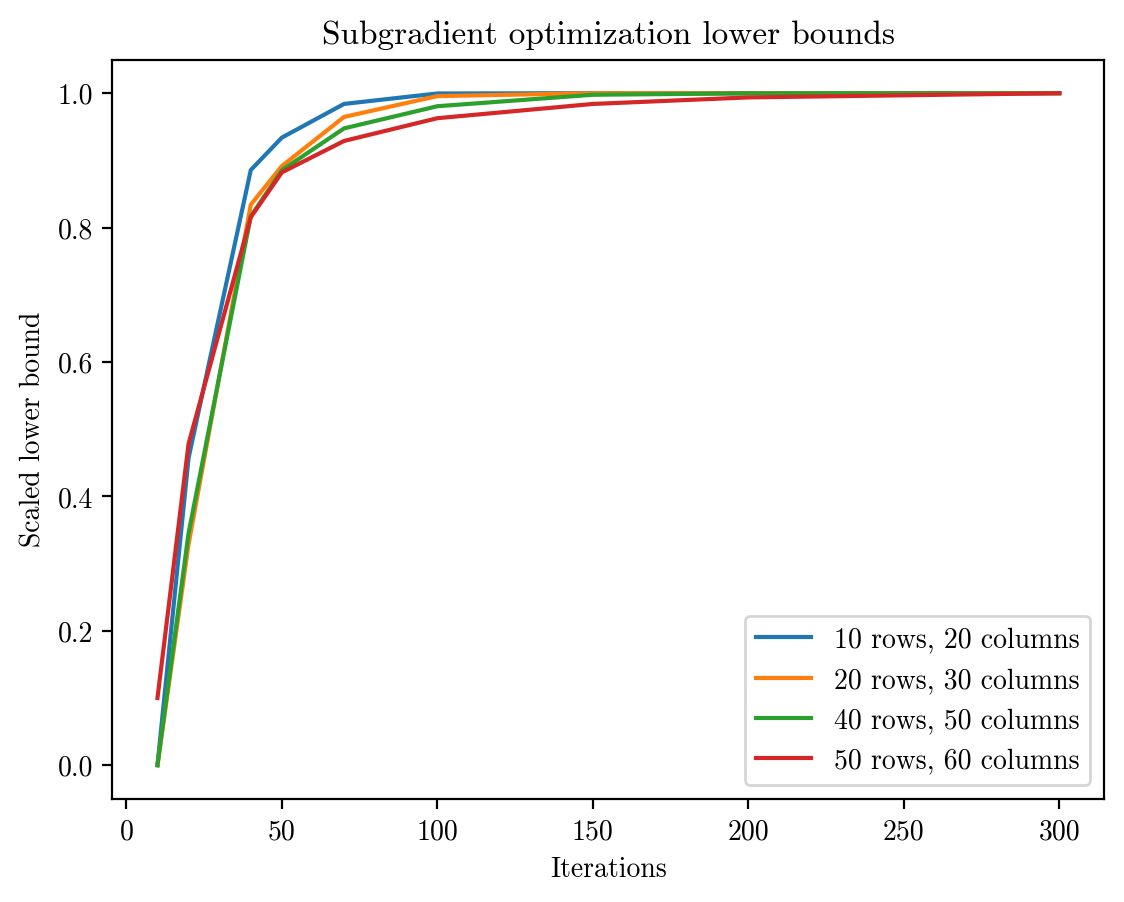

In [8]:
fig, ax = plt.subplots()
for k, v in data.items():
    x = np.array(v)[:,0]
    y = np.array(v)[:,1]
    ax.plot(x, y, label=f"{k[0]} rows, {k[1]} columns")
ax.legend()
ax.set_xlabel("Iterations")
ax.set_ylabel("Scaled lower bound")
ax.set_title("Subgradient optimization lower bounds")
plt.savefig("report/img/subgrad_lb.png", 
            dpi=300, bbox_inches="tight")

In [9]:
gap_ls = []
for _, v in data.items():
    gap_prob = []
    for omega, val in v:
        gap_prob.append(val)
    gap_ls.append(gap_prob)

# omega = 150 at index 6
np.max(1 - np.array(gap_ls)[:,6]).round(3)

0.016

# Branch and Bound models

In [10]:
lagr_callback = LagrPenaltiesReductionCallback()
col_callback = ColumnInclusionCallback()
primal_heur = PrimalHeurCallback()
primal_heur_root = PrimalHeurCallback(only_root=True)

models = {
    "Subgrad": {
        "branch_strategy": branch_reduced_costs, 
        "lb_strategy": subgrad_opt
        },
    "SubgradPrimal": {
        "branch_strategy": branch_reduced_costs, 
        "lb_strategy": subgrad_opt,
        "callbacks": [primal_heur]
        },
    "SubgradPrimalRed": {
        "branch_strategy": branch_reduced_costs, 
        "lb_strategy": subgrad_opt,
        "callbacks": [primal_heur, lagr_callback, col_callback]
        },
    "SubgradPrimalRootRed": {
        "branch_strategy": branch_reduced_costs, 
        "lb_strategy": subgrad_opt,
        "callbacks": [primal_heur_root, lagr_callback, col_callback]
        },
    "SubgradPrimalRedBeasleyBranch": {
        "branch_strategy": branch_beasley, 
        "lb_strategy": subgrad_opt,
        "callbacks": [primal_heur, lagr_callback, col_callback]
        },
    "LPPrimalRed": {
        "branch_strategy": branch_lp, 
        "lb_strategy": lp_rel,
        "callbacks": [primal_heur, col_callback]}
}
short_names = {
    "Gurobi": "Gurobi",
    "Subgrad": "S",
    "SubgradPrimal": "SP",
    "SubgradPrimalRed": "SPR",
    "SubgradPrimalRootRed": "SPRR",
    "SubgradPrimalRedBeasleyBranch": "SPRB",
    "LPPrimalRed": "LP"
}
col_names = ["S", "SP", "SPR", "SPRR", "SPRB", "LP"]

In [ ]:
data = {}
time_limit = 60 * 5
for rows, cols, density in tqdm(
    [(5, 10, 0.3), (5, 10, 0.5), (5, 10, 0.7), 
     (10, 20, 0.3), (10, 20, 0.5), (10, 20, 0.7),
     (13, 22, 0.3), (13, 22, 0.5), (13, 22, 0.7),
     (15, 25, 0.3), (15, 25, 0.5), (15, 25, 0.7),
     (20, 40, 0.3), (20, 40, 0.5), (20, 40, 0.7)],
     desc="Problem:", leave=False):
    res = {}
    A, b = generate_problem(rows, cols, density)
    
    start = time.process_time()
    m = gp.Model()
    m.Params.LogToConsole = 0
    x = m.addMVar(A.shape[-1], vtype=GRB.BINARY, name="x")
    m.setObjective(np.sum(A, axis=0) @ x)
    m.addConstr(A @ x >= b)
    m.optimize()
    elapsed = time.process_time() - start
    opt_gurobi = m.getObjective().getValue()
    
    x = []
    for v in m.getVars():
        x.append(v.x)
    x = np.array(x)
    
    # Make sure that the solution is feasible
    assert np.all(A @ x >= b)

    res["Gurobi"] = (elapsed, m.NodeCount)

    for model, config in tqdm(
        models.items(), desc="Model:", leave=False):
        start = time.process_time()
        bb = BranchAndBound(**config, time_start=start, 
                            time_limit=time_limit)
        try:
            bb.search(A, b)
            elapsed = time.process_time() - start
            x = np.zeros(A.shape[-1])
            x[bb.best.x1] = 1
            
            # Make sure that the solution is feasible
            assert np.all(A @ x >= b)
            opt = np.sum(A, axis=0) @ x

            # Check that the solution is optimal
            assert opt == opt_gurobi
            res[model] = (elapsed, bb.node_count)
        except TimeLimitException:
            res[model] = (np.nan, np.nan)
        
    data[(rows, cols, density)] = res

In [ ]:
with open("results/models.json", "w") as f:
    nd = {str(k): v for k, v in data.items()}
    json.dump(nd, f)

In [11]:
with open("results/models.json", "r") as f:
    results = json.load(f)

In [12]:
time_dict = {
    tuple(k[1:-1].split(", ")): {
        short_names[model]: values[0] for model, values in v.items()}  
    for k, v in results.items()}
df = pd.DataFrame(time_dict)
df = df.T.round(2)
df = df.rename_axis(["Rows", "Columns", "Density"])
df

Gurobi      S      SP    SPR   SPRR    SPRB      LP
Rows Columns Density                                                     
5    10      0.3        0.02   0.00    0.00   0.00   0.00    0.00    0.00
             0.5        0.00   0.09    0.17   0.14   0.12    0.14    0.11
             0.7        0.00   0.02    0.06   0.03   0.00    0.02    0.19
10   20      0.3        0.00  11.47   14.58   3.88   3.06    3.06   39.77
             0.5        0.02  23.44   24.75   5.72   4.84    5.22   83.11
             0.7        0.03  19.81   18.69   1.95   1.86    1.86  165.83
13   22      0.3        0.02  42.72   49.08   6.75   6.47    2.62   94.09
             0.5        0.00  16.12   19.83   2.98   2.80    2.45     NaN
             0.7        0.02  28.42   28.73   1.31   1.50    1.33     NaN
15   25      0.3        0.00  19.08   23.19   5.38   5.69    2.75     NaN
             0.5        0.02  28.47   29.22   5.08   3.77    4.33     NaN
             0.7        0.05  84.94  100.38  15.56  13.75   15.64     NaN
20   40      0.3        0.03    NaN     NaN    NaN    NaN     NaN     NaN
             0.5        0.38    NaN     NaN    NaN    NaN  253.97     NaN
             0.7        0.31    NaN     NaN    NaN    NaN     NaN     NaN

In [13]:
s = df.style.format("{:.2f}") \
            .highlight_min(subset=col_names, 
                           axis=1, props="bfseries: ;")
print(s.to_latex(column_format="lllccccccc", 
                 hrules=True, 
                 clines="skip-last;data",
                 caption="Runtime of different configurations of the branch-and-bound algorithm over randomly generated TRAP instances with different numbers of rows and columns and different densities. Configurations whose runtime exceeded 5 minutes were assigned nan values. The best result obtained by algorithms other than Gurobi is highlighted in bold for each problem instance. The runtime was measured in seconds.",
                 label="tab:results:runtime", 
                 position_float="centering"))

\begin{table}
\centering
\caption{Runtime of different configurations of the branch-and-bound algorithm over randomly generated TRAP instances with different numbers of rows and columns and different densities. Configurations whose runtime exceeded 5 minutes were assigned nan values. The best result obtained by algorithms other than Gurobi is highlighted in bold for each problem instance. The runtime was measured in seconds.}
\label{tab:results:runtime}
\begin{tabular}{lllccccccc}
\toprule
 &  &  & Gurobi & S & SP & SPR & SPRR & SPRB & LP \\
Rows & Columns & Density &  &  &  &  &  &  &  \\
\midrule
\multirow[c]{3}{*}{5} & \multirow[c]{3}{*}{10} & 0.3 & 0.02 & \bfseries 0.00 & \bfseries 0.00 & \bfseries 0.00 & \bfseries 0.00 & \bfseries 0.00 & \bfseries 0.00 \\
 &  & 0.5 & 0.00 & \bfseries 0.09 & 0.17 & 0.14 & 0.12 & 0.14 & 0.11 \\
 &  & 0.7 & 0.00 & 0.02 & 0.06 & 0.03 & \bfseries 0.00 & 0.02 & 0.19 \\
\cline{1-10} \cline{2-10}
\multirow[c]{3}{*}{10} & \multirow[c]{3}{*}{20} & 0.3 & 0.0

In [14]:
nodes_dict = {
    tuple(k[1:-1].split(", ")): {
        short_names[model]: values[1] for model, values in v.items()}  
    for k, v in results.items()}
df = pd.DataFrame(nodes_dict)
df = df.T
df = df.rename_axis(["Rows", "Columns", "Density"])
df

Gurobi        S       SP     SPR    SPRR     SPRB  \
Rows Columns Density                                                      
5    10      0.3         0.0     17.0     15.0     5.0     5.0      7.0   
             0.5         1.0    179.0    185.0    63.0    63.0     63.0   
             0.7         1.0     75.0     85.0    23.0    23.0     23.0   
10   20      0.3         1.0   9131.0   8659.0  1607.0  1761.0   1205.0   
             0.5        50.0  15421.0  14115.0  2469.0  2781.0   2337.0   
             0.7        25.0  14057.0   8705.0   609.0   607.0    559.0   
13   22      0.3         1.0  25257.0  26033.0  2427.0  2849.0    907.0   
             0.5         1.0   9147.0   8837.0   949.0   951.0    795.0   
             0.7         1.0  18929.0  14419.0   371.0   501.0    453.0   
15   25      0.3         1.0  13387.0  13475.0  1631.0  2077.0    833.0   
             0.5        59.0  15903.0  14897.0  1731.0  1657.0   1541.0   
             0.7       384.0  53149.0  50545.0  4549.0  5315.0   4841.0   
20   40      0.3       174.0      NaN      NaN     NaN     NaN      NaN   
             0.5       573.0      NaN      NaN     NaN     NaN  62615.0   
             0.7      1865.0      NaN      NaN     NaN     NaN      NaN   

                            LP  
Rows Columns Density            
5    10      0.3          23.0  
             0.5         183.0  
             0.7         323.0  
10   20      0.3       55541.0  
             0.5      124795.0  
             0.7      209799.0  
13   22      0.3      117271.0  
             0.5           NaN  
             0.7           NaN  
15   25      0.3           NaN  
             0.5           NaN  
             0.7           NaN  
20   40      0.3           NaN  
             0.5           NaN  
             0.7           NaN

In [15]:
s = df.style.format("{:.0f}") \
            .highlight_min(subset=col_names, 
                           axis=1, props="bfseries: ;")
print(s.to_latex(column_format="lllccccccc", 
                 hrules=True, 
                 clines="skip-last;data",
                 caption="Number of nodes generated by different configurations of the branch-and-bound algorithm over randomly generated TRAP instances with different numbers of rows and columns and different densities. Configurations whose runtime exceeded 5 minutes were assigned nan values. The best result obtained by algorithms other than Gurobi is highlighted in bold for each problem instance.",
                 label="tab:results:nodes", 
                 position_float="centering"))

\begin{table}
\centering
\caption{Number of nodes generated by different configurations of the branch-and-bound algorithm over randomly generated TRAP instances with different numbers of rows and columns and different densities. Configurations whose runtime exceeded 5 minutes were assigned nan values. The best result obtained by algorithms other than Gurobi is highlighted in bold for each problem instance.}
\label{tab:results:nodes}
\begin{tabular}{lllccccccc}
\toprule
 &  &  & Gurobi & S & SP & SPR & SPRR & SPRB & LP \\
Rows & Columns & Density &  &  &  &  &  &  &  \\
\midrule
\multirow[c]{3}{*}{5} & \multirow[c]{3}{*}{10} & 0.3 & 0 & 17 & 15 & \bfseries 5 & \bfseries 5 & 7 & 23 \\
 &  & 0.5 & 1 & 179 & 185 & \bfseries 63 & \bfseries 63 & \bfseries 63 & 183 \\
 &  & 0.7 & 1 & 75 & 85 & \bfseries 23 & \bfseries 23 & \bfseries 23 & 323 \\
\cline{1-10} \cline{2-10}
\multirow[c]{3}{*}{10} & \multirow[c]{3}{*}{20} & 0.3 & 1 & 9131 & 8659 & 1607 & 1761 & \bfseries 1205 & 55541 \\
 &  & 0.5 